<a href="https://colab.research.google.com/github/prakharsinghch/QML/blob/main/MODEL_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Model 1

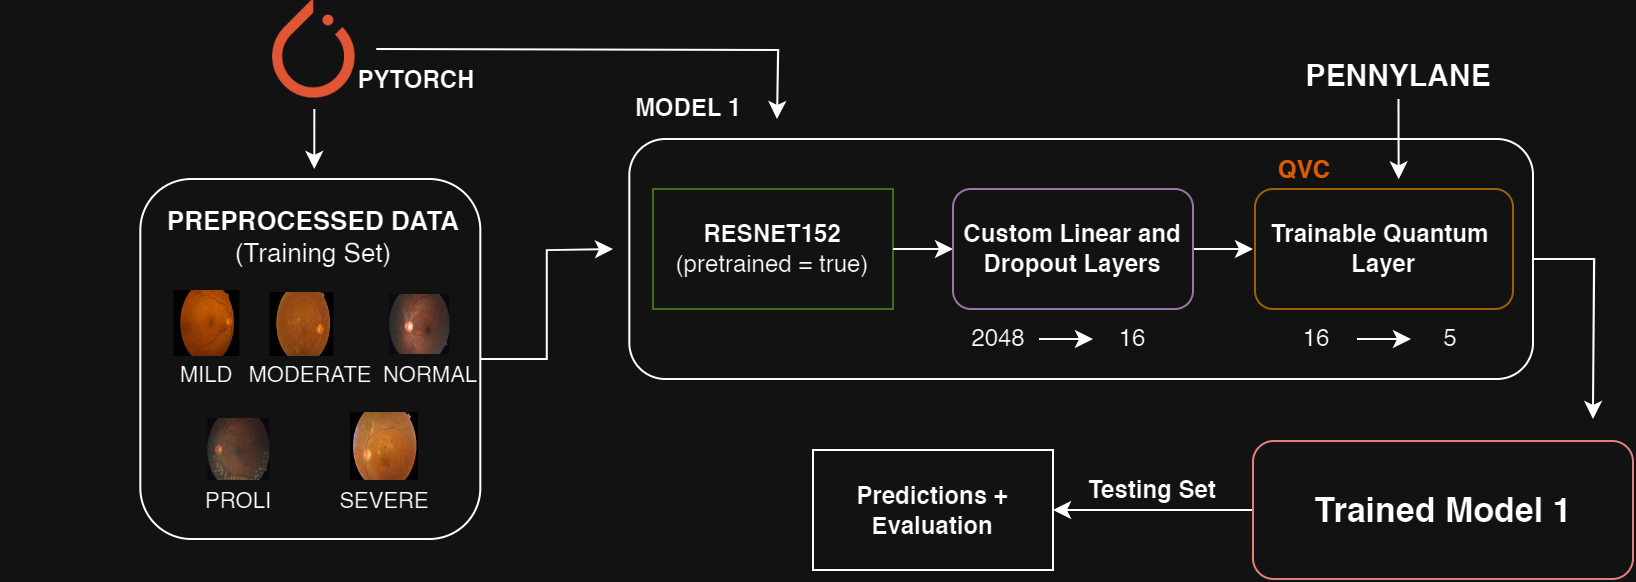

#Importing Dependencies

In [ ]:
import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2

# Dataset Downloading

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-2019-data

100% 237M/238M [00:11<00:00, 23.7MB/s]
100% 238M/238M [00:11<00:00, 21.8MB/s]


#Dataset Augmentation and Preprocessing
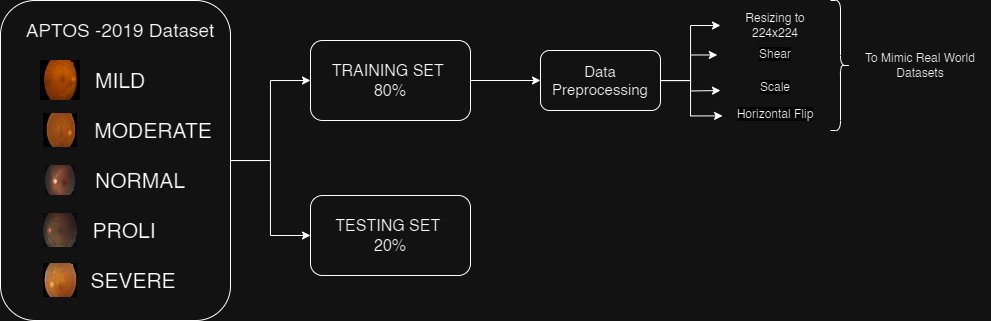

In [ ]:
import zipfile
def unzip(filename):
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

import os

In [ ]:
unzip("/content/diabetic-retinopathy-224x224-2019-data.zip")

In [ ]:
data_path = "/content/colored_images"

In [ ]:
!pip install split-folders
import splitfolders
splitfolders.ratio(data_path, output="/content/aptos", seed=42, ratio=(0.8, 0.2))

Copying files: 3662 files [00:01, 3425.79 files/s]


In [ ]:
input_path = "/content/aptos/"

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train':
    datasets.ImageFolder(input_path + 'train', data_transforms['train']),
    'validation':
    datasets.ImageFolder(input_path + 'val', data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=1),  # for Kaggle
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=1)  # for Kaggle
}

#Downloading Pennylane and Declaring Hyperparameters

In [ ]:
%%capture

# Comment this out if you don't want to install pennylane from this notebook
!pip install pennylane

# Comment this out if you don't want to install matplotlib from this notebook
!pip install matplotlib

In [ ]:
import pennylane as qml
from pennylane import numpy as np

In [ ]:
n_qubits = 8               # Number of qubits
batch_size = 32           # Number of samples for each training step
q_depth = 10                 # Depth of the quantum circuit (number of variational layers)
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()

In [ ]:
dev = qml.device("default.qubit", wires=n_qubits)  # a simple state simulator of qubit-based quantum circuit architectures provided by pennylane

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Model Creation

#Quantum Variational Circuit

#Basic Layers for Quantum Circuit

1. Hadamard Gate. No. of Qubits = 8

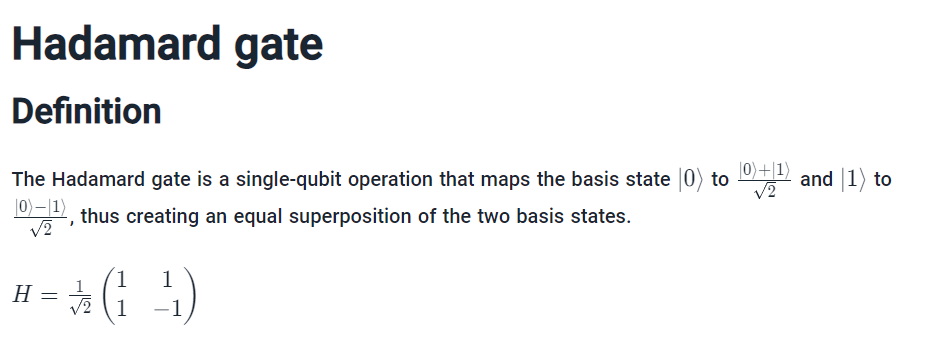

2. Ry Layer

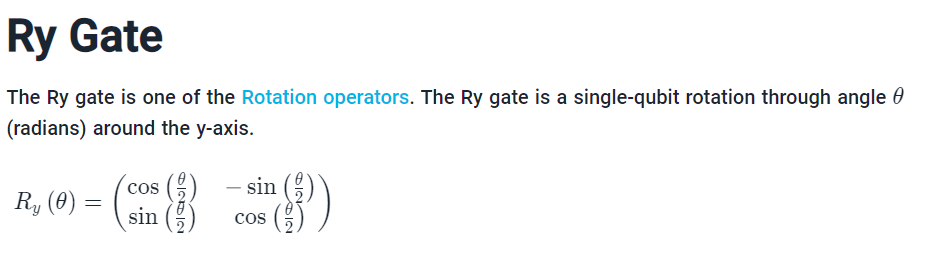

3. Shifted Layer of CNOT Gates

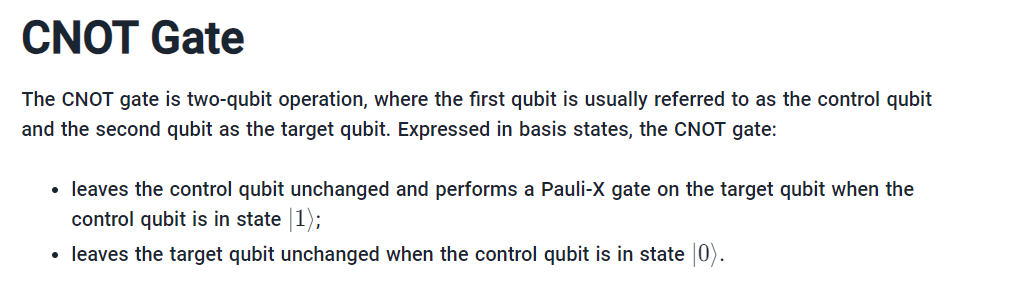





In [ ]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])


# PennyLane qnode decorator

The structure is that of a typical variational quantum circuit:

**Embedding layer:** All qubits are first initialized in a balanced superposition of up and down states, then they are rotated according to the input parameters (local embedding).

**Variational layers:** A sequence of trainable rotation layers and constant entangling layers is applied.

**Measurement layer:** For each qubit, the local expectation value of the Z operator is measured. This produces a classical output vector, suitable for additional post-processing.

In [ ]:
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)


#Dressed quantum circuit

We can now define a custom `torch.nn.Module` representing a dressed quantum circuit.

This is a concatenation of:


*   A classical pre-processing layer (nn.Linear).
*   A classical activation function (torch.tanh).
*   A constant np.pi/2.0 scaling.
*   The previously defined quantum circuit (quantum_net).
*   A classical post-processing layer (nn.Linear).

The input of the module is a batch of vectors with **16 real parameters** (features) and the output is a batch of vectors with 5 real outputs (associated with the five classes of images: **Mild, Moderate, Normal, Proliferate and Severe**)

In [ ]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()

        self.pre_net = nn.Linear(16,n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 5)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)



# Hybrid Classical-Quantum Model

We are finally ready to build our full hybrid classical-quantum network. We follow the transfer learning approach:




1.   First load the classical pre-trained network ResNet152 from the torchvision.models zoo with Resne-50 weights.
2.   Freeze all the weights since they should not be trained.
3. Add your custom layers to the pre-trained model.
4. Replace the last fully connected layer with our trainable dressed quantum circuit (DressedQuantumNet).









In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

In [ ]:
model1 = torchvision.models.resnet152(pretrained = True, weights = ResNet50_Weights)


for param in model1.parameters():
    param.requires_grad = False





model1.fc = nn.Sequential(
    nn.Linear(2048, 512),
    # nn.Linear(1920,512),
    nn.ReLU(inplace = True),
    nn.Linear(512,256),
    nn.ReLU(inplace = True),
    nn.Linear(256,128),
    nn.Linear(128,64),
    nn.ReLU(inplace = True),
    nn.Linear(64,32),
    nn.Linear(32,16),
    # nn.Linear(16,8),
    DressedQuantumNet()
)


model1.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 197MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#Model Training

In [ ]:
test_acc , train_acc, test_loss, train_loss = [], [], [], []

def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            if(phase == "train"):
                train_acc.append(epoch_acc)
                train_loss.append(epoch_loss)

            else:
                test_acc.append(epoch_acc)
                test_loss.append(epoch_loss)
    return model

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.fc.parameters())

In [ ]:
model_trained = train_model(model1, criterion, optimizer, num_epochs=10)

Epoch 1/10
----------
train loss: 1.0913, acc: 0.6378
validation loss: 1.0182, acc: 0.6480
Epoch 2/10
----------
train loss: 0.8992, acc: 0.7060
validation loss: 0.8506, acc: 0.7244
Epoch 3/10
----------
train loss: 0.8350, acc: 0.7204
validation loss: 0.8005, acc: 0.7258
Epoch 4/10
----------
train loss: 0.8083, acc: 0.7221
validation loss: 0.9773, acc: 0.6712
Epoch 5/10
----------
train loss: 0.8044, acc: 0.7272
validation loss: 0.7572, acc: 0.7394
Epoch 6/10
----------
train loss: 0.8089, acc: 0.7197
validation loss: 0.7406, acc: 0.7394
Epoch 7/10
----------
train loss: 0.8090, acc: 0.7177
validation loss: 0.7451, acc: 0.7408
Epoch 8/10
----------
train loss: 0.7630, acc: 0.7299
validation loss: 0.7333, acc: 0.7394
Epoch 9/10
----------
train loss: 0.7603, acc: 0.7289
validation loss: 0.7264, acc: 0.7381
Epoch 10/10
----------
train loss: 0.7601, acc: 0.7269
validation loss: 0.7045, acc: 0.7435


In [ ]:
te_acc = []

for i in test_acc :
  te_acc.append(i.cpu())

tr_acc = []

for i in train_acc :
  tr_acc.append(i.cpu())


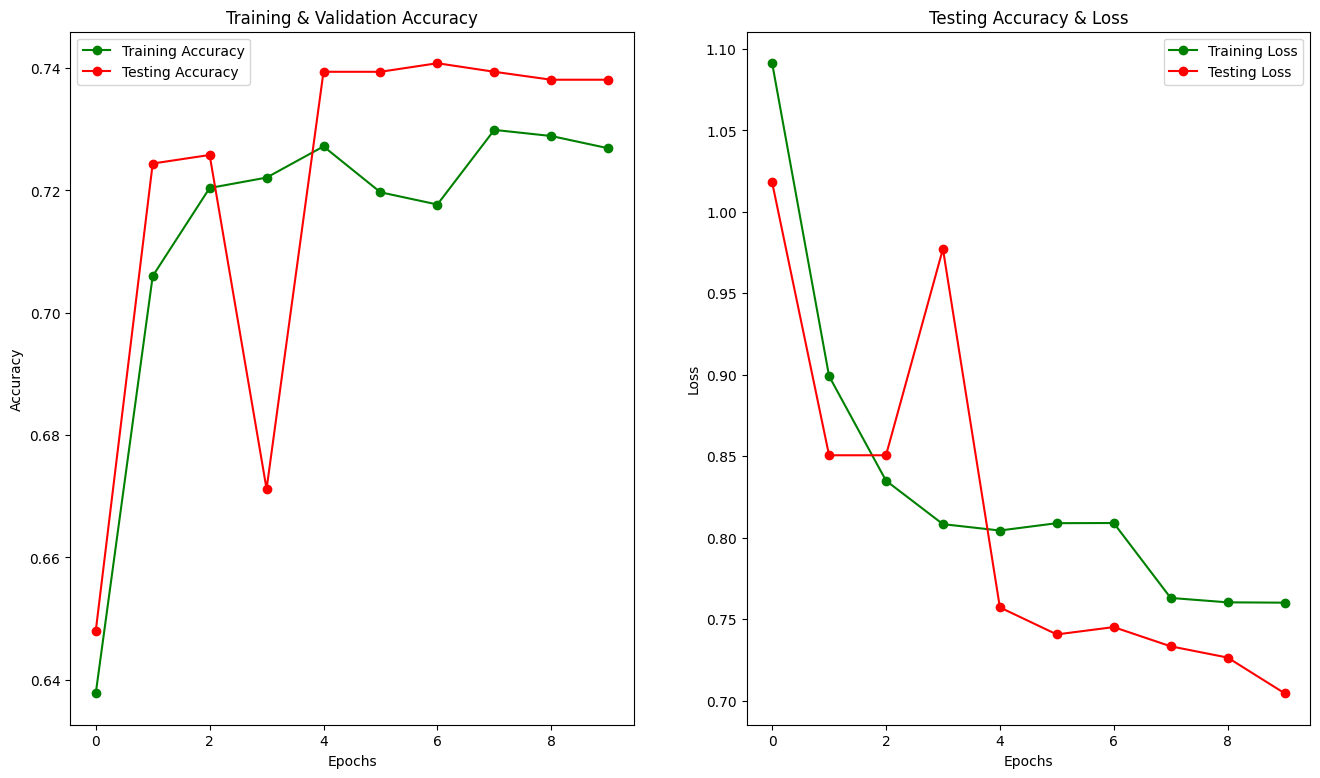

In [ ]:
import matplotlib.pyplot as plt
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = tr_acc
train_loss = train_loss
val_acc = te_acc
val_loss = test_loss
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

#Saving Model to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(model1.state_dict(), 'model2_final.pth')

# Confusion Matrix and Classification Metrics

In [ ]:
phase = "validation"

In [ ]:
y_preds = []
label = []

model1.eval()
for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model1(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                y_preds.append(preds.cpu())
                label.append(labels.cpu())

In [ ]:
y_pred = np.array(y_preds[0])
y_true = np.array(label[0])

for i in range(1,len(y_preds)):
  y_pred = np.append(y_pred, np.array(y_preds[i]))

for i in range(1,len(label)):
  y_true = np.append(y_true, np.array(label[i]))



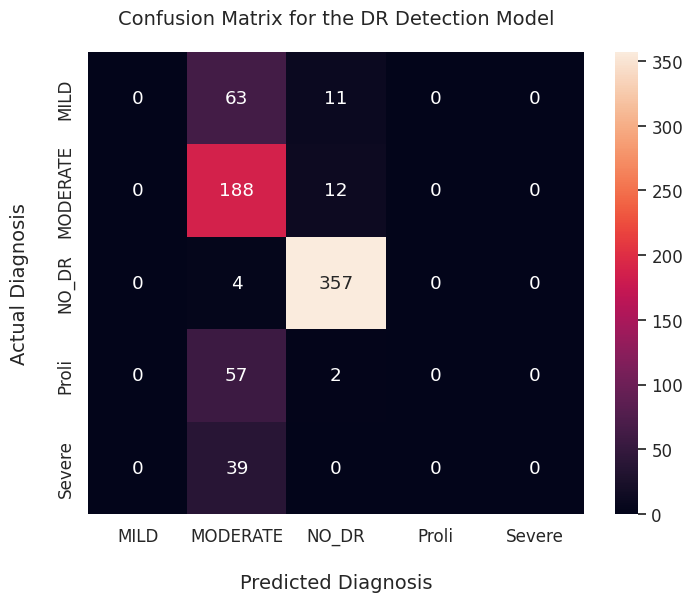

In [ ]:
from sklearn.metrics import confusion_matrix
cnf = confusion_matrix(y_true, y_pred)


import seaborn as sns

from sklearn.metrics import confusion_matrix
cnf = confusion_matrix(y_true, y_pred)


import seaborn as sns


plt.figure(figsize=(8,6), dpi=100)

sns.set(font_scale = 1.1)

ax = sns.heatmap(cnf, annot=True, fmt='d', )


ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['MILD','MODERATE', 'NO_DR','Proli', 'Severe'])

ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['MILD','MODERATE', 'NO_DR','Proli', 'Severe'])
# set plot title
ax.set_title("Confusion Matrix for the DR Detection Model", fontsize=14, pad=20)

plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn

classes = ('MILD','MODERATE', 'NO_DR','Proli', 'Severe')

print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

        MILD       0.00      0.00      0.00        74
    MODERATE       0.54      0.94      0.68       200
       NO_DR       0.93      0.99      0.96       361
       Proli       0.00      0.00      0.00        59
      Severe       0.00      0.00      0.00        39

    accuracy                           0.74       733
   macro avg       0.29      0.39      0.33       733
weighted avg       0.61      0.74      0.66       733



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Fetching Predictions from Model

In [ ]:
from PIL import Image

In [ ]:
validation_img_paths = ["/content/aptos/val/Moderate/094858f005ab.png",
                        "/content/aptos/val/No_DR/08ee569d4721.png",
                        "/content/aptos/val/Proliferate_DR/15e96e848b46.png"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]


In [ ]:
validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])

In [ ]:
pred_logits_tensor = model1(validation_batch)
pred_logits_tensor

tensor([[ 0.2830,  0.8691, -0.0544, -0.4768, -0.7789],
        [-0.7575, -1.0310,  3.2294, -1.8322, -2.3241],
        [ 0.1711,  1.6152, -1.7282,  0.4140,  0.0646]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
pred_probs = torch.nn.functional.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[0.2312634 , 0.4155607 , 0.16502894, 0.10817213, 0.07997479],
       [0.01779434, 0.01353601, 0.95888054, 0.00607456, 0.00371456],
       [0.13224664, 0.56047064, 0.01979394, 0.16860202, 0.11888677]],
      dtype=float32)

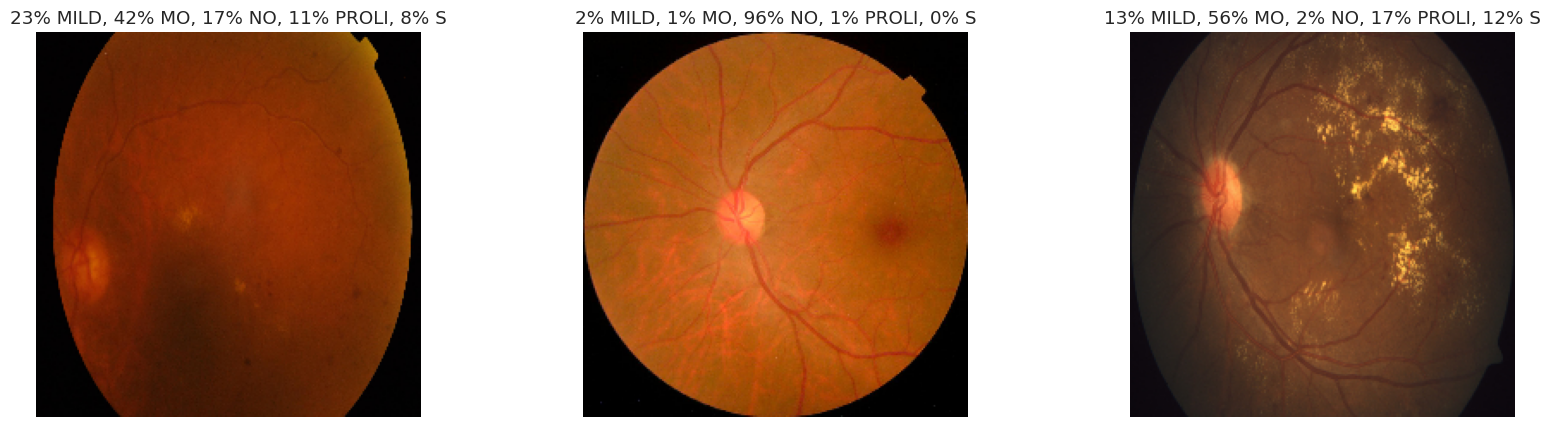

In [ ]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% MILD, {:.0f}% MO, {:.0f}% NO, {:.0f}% PROLI, {:.0f}% S".format( 100*pred_probs[i,0],
                                                            100*pred_probs[i,1], 100*pred_probs[i,2],100*pred_probs[i,3], 100*pred_probs[i,4]))
    ax.imshow(img)